In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# Selected news organizations
news_handles = ("@BBCNews", "@FoxNews", "@CBSNews", "@CNN", "@nytimes")

counter = 1

sentiments = []

oldest_tweet = None

# Loop through all target users
for news in news_handles:

    # Loop through 6 pages of tweets
    for x in range(6):

        # Run search around each tweet
        public_tweets = api.user_timeline(news, max_id=oldest_tweet)

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter
                
            # Set the new oldest_tweet value
            oldest_tweet = tweet["id"] - 1

        # Store the sentiments in a list 
            sentiments.append({"News Source": news,
                            "Date": tweet['created_at'],
                            "Tweet": tweet["text"],
                            "Compound": compound,
                            "Positive": pos,
                            "Neutral": neg,
                            "Negative": neu,
                            "Tweets Ago": counter
                            })
            counter += 1
            if counter == 125:
                counter = 1


In [3]:
#convert the sentiment and tweet data into a df

sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd.tail()

,Compound,Date,Negative,Neutral,News Source,Positive,Tweet,Tweets Ago
595,0.6369,Mon Jul 09 20:31:05 +0000 2018,0.682,0.000,@nytimes,0.318,RT @tmagazine: T’s Best Photographs From Coutu...,100
596,0.0000,Mon Jul 09 20:16:02 +0000 2018,1.000,0.000,@nytimes,0.000,Think about making a double batch of this humm...,101
597,0.0000,Mon Jul 09 20:01:04 +0000 2018,1.000,0.000,@nytimes,0.000,Washington is known more for power politics th...,102
598,-0.5106,Mon Jul 09 19:49:41 +0000 2018,0.683,0.232,@nytimes,0.085,RT @nkulish: The Costs Human Smuggling: How de...,103
599,0.0000,Mon Jul 09 19:31:04 +0000 2018,1.000,0.000,@nytimes,0.000,A harmful algae bloom has covered 90 percent o...,104


In [4]:
#reorganize columns more logically 

sentiments_pd = sentiments_pd[["News Source", "Tweet", "Tweets Ago", "Date", "Compound", "Positive", "Neutral", "Negative"]]

In [5]:
sentiments_pd.head()

,News Source,Tweet,Tweets Ago,Date,Compound,Positive,Neutral,Negative
0,@BBCNews,Newspaper headlines: Trump's 'fake schmooze' o...,1,Fri Jul 13 23:01:37 +0000 2018,-0.4767,0.0,0.279,0.721
1,@BBCNews,Scarlett Johansson quits trans role after LGBT...,2,Fri Jul 13 21:48:19 +0000 2018,0.0000,0.0,0.000,1.000
2,@BBCNews,Pakistan election: More than 100 die in bomb a...,3,Fri Jul 13 20:07:34 +0000 2018,-0.8824,0.0,0.507,0.493
3,@BBCNews,Trump May meeting: The Wacky Races of press co...,4,Fri Jul 13 19:13:41 +0000 2018,0.0000,0.0,0.000,1.000
4,@BBCNews,Wimbledon 2018: Kevin Anderson beats John Isne...,5,Fri Jul 13 19:08:49 +0000 2018,0.0000,0.0,0.000,1.000


In [10]:
#export the data to a csv

sentiments_pd.to_csv("twitter_news_sentiments.csv")

In [7]:
#group by average sentiment scores by news organization 

summary_pd = sentiments_pd.groupby('News Source').mean()
summary_pd.reset_index(inplace=True)
summary_pd.head()

,News Source,Tweets Ago,Compound,Positive,Neutral,Negative
0,@BBCNews,60.500000,-0.022825,0.069417,0.087417,0.843150
1,@CBSNews,60.766667,-0.113623,0.062417,0.112533,0.825058
2,@CNN,60.900000,0.070060,0.081817,0.056183,0.861992
3,@FoxNews,60.633333,0.038614,0.080008,0.068992,0.851000
4,@nytimes,61.033333,0.044912,0.074767,0.062008,0.863225


In [ ]:
#Plot scatterplot of all tweets sentiments 

plt.figure(figsize=(12,8))
sns.lmplot(x='Tweets Ago', y='Compound', data=sentiments_pd, palette=['blue', 'green','red', 'orange','silver'], \
           fit_reg=False, hue='News Source', legend_out=False)
plt.title("Unique Tweet Sentiment by News Organization 7/13/2018", fontsize=14)
plt.xlabel('Number of Tweets Ago', fontsize=14)
plt.ylabel('Tweet Sentiment', fontsize=14)
plt.legend(bbox_to_anchor=(1.1, 1), loc=2, borderaxespad=0)
plt.grid()
plt.savefig("tweetsentiment_vs_newsorg1.png")

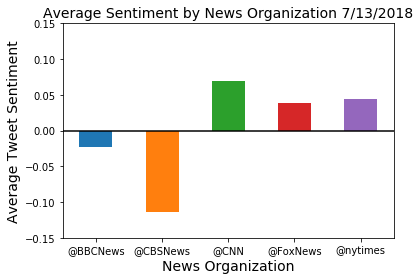

<Figure size 432x288 with 0 Axes>

In [12]:
#Plot the average sentiment by news organization 

ax = summary_pd.plot.bar(x='News Source', y='Compound', rot=0)
plt.title("Average Sentiment by News Organization 7/13/2018", fontsize=14)
plt.xlabel('News Organization', fontsize=14)
plt.ylabel('Average Tweet Sentiment', fontsize=14)
ax.legend_.remove()
plt.tight_layout()
plt.axhline(0, color='black')
plt.ylim(-.15, .15)
plt.show()
plt.savefig("tweetsentiment_vs_newsorg2.png")